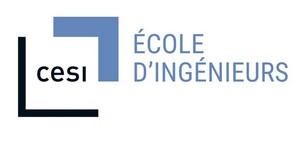

<h1 align='center'>Projet Leyenda - Livrable 2 - Traitement d'images</h1>
<h3 align='center'>Youssef AYARI, Matthieu DECLERCQ, Thomas PETAIN, Julien BARON, Jean-Baptiste CASTELLANI</h1>

## Sommaire

* [Introduction](#chapter1)
* [1. Contraintes](#chapter2)
* [2. Configuration de l'environnement](#chapter3)
    * [2.1 Import des librairies Python](#section_2_1)
    * [2.2 Utilisation du GPU](#section_2_2)
* [3. Préparation du dataset](#chapter4)
    * [3.1 Création d'un jeu d'entraînement et de test](#section_3_1)
    * [3.2 Bruitage du jeu de données](#section_3_2)
* [4. Création du Modèle](#chapter5)
    * [4.1 Encodeur Décodeur](#section_5_1)
    * [4.2 Implémentation du modèle](#section_5_2)
    * [4.3 Amélioration du modèle](#section_5_3)
* [5. Mesure de la performance](#chapter6)
* [6. Etude de cas](#chapiter7)
* [7. Conclusion](#chapiter8)

## Introduction <a class="anchor" id="chapter1"></a>

<div style="text-align: justify">Dans le cadre de ce projet, l'entreprise TouNum, spécialisée dans la numérisation de documents, souhaite étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, leur clientèle possède une grande quantité de données à numériser au format papier. Dans le but de rester compétitif dans ce secteur d’activité, l’entreprise décide d’innover et de proposer un service de catégorisation qui serait plus que valorisable. Afin de mener à bien cette tâche, des spécialistes en Data Science du CESI ont été contactés.
<p><br>
    
<div style="text-align: justify">Dans la partie précedente nous avons classifié les photos et les autres images par le biais d'un CNN. Dans ce notebook nous abroderons le débruitage des photos afin de faciliter leur traitement par les algorithmes de machine Learning</div>

## 1. Contraintes <a class="anchor" id="chapter2"></a>

<div style="text-align: justify">Dans le but d'opérer une opération de débruitage nous devons réfléchir à une méthode qui nous permettra de réduire la dimension de notre image. En effet, lorsque nous traitons des images nous avons beaucoup de caractéristiques en entrée. Prenons une image 28 x 28 pixel, dans ce cas nous aurons 784 inputs dans notre réseau de neurones. Avec autant de dimension ce qui rend le traitement et l'analyse compliqué.</div><br>

<div style="text-align: justify">Nous connaissons des méthodes permettant de réduire les dimensions de notre image. Nous pouvons citer dans un premier temps l'ACP ( Analyse en Composantes Principale). Néanmoins cette solution ne nous satisfait pas car les relations entre les caractéristiques et les points de données dans un espace à haute dimension présentent une relation non linéaire.</div><br>

<div style="text-align: justify">Dans ce cas de figure nous pouvons alors nous tourner vers le TSNE. Néanmoins, cet algorithme bien que très efficace ne convainc pas du fait qu'il reste très gourmand en ressources. Par conséquent nous nous devons trouver un algorithme qui nous permet de garder une approche non linéaire tout en conservant des performances acceptables.</div><br>


## 2. Configuration de l'environnement <a class="anchor" id="chapter3"></a>

Tout comme dans le premier livrable nous nous devons de préparer notre environnement de travail pour mener à bien notre projet. Par conséquent nous reviendrons sur les mêmes points qui ont été aborder précédemment qui sont : l'import des librairies Python et l'utilisattion du GPU. 

### 2.1 Import des librairies Python <a class="anchor" id="section_3_1"></a>

Dans le cadre de ce premier livrable, nous avons décidé d’importer plusieurs librairies Python que nous allons présenter :
<ul>
    <li style="text-align: justify"><strong>TensorFlow</strong> : est un outil open source d'apprentissage automatique développé par Google. Il est l'un des outils les plus utilisés en IA dans le domaine de l'apprentissage machine. Celui-ci contient de nombreuses implémentations de blocs nécessaire à la construction de réseaux de neurones couramment utilisés tels que des couches, des fonctions d'activation, des optimiseurs et une multitude d'outils pour faciliter le travail avec des images ou des textes afin de simplifier le codage nécessaire à l'écriture de code de réseau de neurones profond. <strong>Keras</strong> est l’API haut niveau s’exécutant sur la plateforme d’apprentissage automatique Tensorflow. Elle permet de faciliter la création et l’entraînement des modèles de deep learning.</li><br>
</ul>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import numpy as np
import pathlib

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model, Sequential
from random import randrange
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers

### 2.2 Utilisation du GPU <a class="anchor" id="section_2_1"></a>

<div style="text-align: justify">Dans l'optique d’avoir de meilleures performances tout au long de ce projet notamment durant l’entraînement du modèle, nous avons décidé de faire passer le traitement des données par le GPU. Pour ce faire, la ligne ci-dessous nous indique si le système détecte un GPU qui peut être utilisé. (Seules les cartes Nvdia avec Cuda installé sont reconnues par Tensorflow).<div>

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 3. Préparation du dataset <a class="anchor" id="chapter4"></a>

<div style="text-align: justify"> Nous avons vu comment dans le premier livrable comment préparer notre jeux de données pour les algorithme de deep learning. Néanmoins, nous devrons rajouter intentionellement du bruit sur nos images dans le but de pouvoir entrainer nos modèles dans les meilleures conditons.</div>

In [3]:
data_dir = r"D:/exia/A5 2021-2022/Option_DataScience/Data"
image_h = 256
image_w = 256
batch_s = 9

### 3.1 Création des jeux d'entrainement et de test <a class="anchor" id="section_4_1"></a>

<div style="text-align: justify">Pour préparer le jeu de données, nous le séparons en deux sous-ensembles homogènes afin d'éviter la sous-représentation de classe. Le premier sous-ensemble dit d'entraînement permettra au modèle d'ajuster ses poids et par conséquent améliorer sa classification. Le second nous permet d'évaluer la classification du modèle. C'est sur ce jeu de données qu'on se base pour le calcul de la précision du modèle.<div>   

In [4]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode="rgb"
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode="rgb"
)

Found 13747 files belonging to 1 classes.
Using 10998 files for training.
Found 13747 files belonging to 1 classes.
Using 2749 files for validation.


### 3.2 Bruitage du jeu de données <a class="anchor" id="section_4_2"></a>

<div style="text-align: justify">Notre dataset ne contenant pas d'image bruitée, nous devons par conséquent ajouter un bruit gaussien aléatoire sur chaque image. Pour ce faire nous générons aléatoirement un entier que nous multiplions par un facteur et additionnons à notre image.</div>

In [12]:
#process image 
def preprocess(data, is_batch = True):
    batch_size = len(data) if is_batch else 1
    data = np.array(data, dtype=np.float32) #conversion de l'image en narray de nombre de flotan
    data = data.astype('float32') / 255.0 #Normalisation des données de narray
    data = np.reshape(data, (batch_size, image_h, image_w, 3))# redimensionnement de l'array
    return data

#Bruitage de l'image
def noise_it(data, noise_factor = 0.2):
    data_noisy = data + noise_factor * tf.random.normal(shape = data.shape)
    return np.clip(data_noisy, 0., 1.)#Normalization des données après le bruitage
    
#Sépare les features des labels 
def split_dataset(data):
    for photo_batch, label_batch in data:
        photo = photo_batch
        break
    return photo

x_train = split_dataset(train_set)
x_test = split_dataset(test_set)

x_train = preprocess(x_train)
x_test = preprocess(x_test)

x_train_noisy = noise_it(x_train) 
x_test_noisy = noise_it(x_test)

Nous pouvons voir ci-dessous que les images issus de notre dataset on bien été bruité.

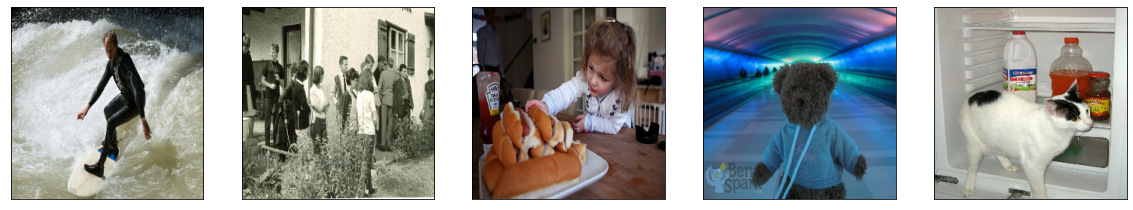

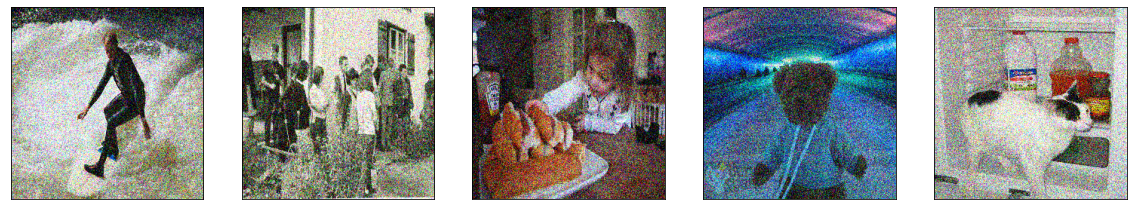

In [29]:
#Affichage d'image
def display_image(X, n, size = 20):
    plt.figure(figsize=(size, size))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_image(x_train,5)
display_image(x_train_noisy, 5)

## 4 Création du modèle <a class="anchor" id="chapter5"></a>

<div style="text-align: justify">Nous avons maintenaint un dataset nétoyé et prêt à être exploité pour l'entrainement des modèles. Par conséquent cette partie s'axe sur le dévloppement et l'évaluation du modèle.</div>

### 4.1 Encodeur Décodeur <a class="anchor" id = "section_5_1">

<div style="text-align: justify">Cette architecture fonctionne sur la base de 2 concepts qui nous permettrons de prendre en entré une image bruité :</div><br>

<div style="text-align: justify">-<strong>l'Encodeur</strong>: L'objectif de cette étape est de sous-échantillonner l’image en entrée. Pour ce faire nous allons utiliser des opérations de convolution comme vu précédemment dans le livrable 1. Ce qui aura pour conséquence de réduire la taille de l’image d’entrée. A la suite des opérations de convolution nous obtiendrons une représentation vectorielle de notre image appelée espace latent.</div><br>

<div style="text-align: justify">-<strong>Décodeur</strong>: La seconde partie appelée décodeur prend en entrée l’espace latent généré par l’encodeur. Son objectif sera de reconstruire l’image en supprimant le bruit . Pour ce faire, nous utilisons des couches de convolutions transposées. Ces couches, vont rééchantillonner l’image à partir des caractéristiques de l’espace latent. Comme le montre le schéma ci-dessous :</div><br>

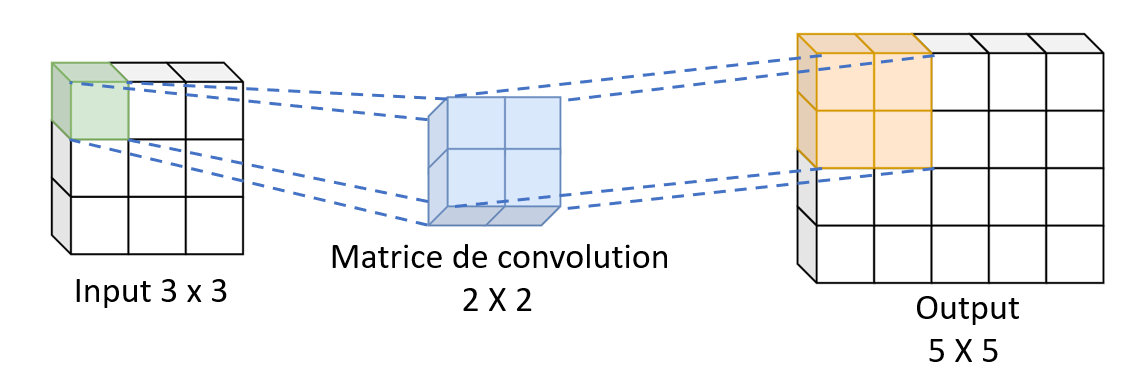
<br>

<div style="text-align: justify">Cette architecture répond parfaitement à la problématique posée précédemment dans le notebook. En effet, nous avons pu diminuer la dimension de manière non-linéaire tout en gardant des performances qui sont très acceptables.</div>


### 4.2 Implémentation du modèle <a class="anchor" id = "section_5_2">

<div style="text-align: justify">Dans cette partie nous allons implémenter le modèle d’auto-encodeur décrit précédemment. Nous définissons au préalable les variables utiles au modèle tel que le nombre d'époque ou la taille du batch.</div>

In [ ]:
nb_epochs = 1000
batch_size = 18

#### 4.2.1 Définition du modèle <a class="anchor" id = "section_5_2_1">

<div style="text-align: justify">Le code ci-dessous représente les différentes couches de convolution et de transposé utile à la reconstruction de l'image. Nous précisons les différents taille de filtre et de kernel ainsi que les fonctions d'activation.</div><br>

<div style="text-align: justify">Dans le but de minimiser notre fonction coût nous avons choisi l'optimiseur Adam. Cet algorithme d'optimisation est utilisé pour la formation de modèles d'apprentissage profond. Il s'agit d'une extension de la descente de gradient. </div>

In [ ]:
inputs = Input(shape=(image_w, image_w, 3))

#Encoder
x = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)


# Decoder
x = Conv2D(256, (3, 3),  activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3),  activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(inputs, x)
model_opt = tf.keras.optimizers.Adam()
autoencoder.compile(optimizer=model_opt, loss="binary_crossentropy")
autoencoder.summary()

#### 4.2.3 Sauvegarde du meilleure modèle  <a class="anchor" id="section_5_2_3"></a>

<div style="text-align: justify">Une fois les différentes époques éffectué nous sauvegardons les poids du meilleur model obtenue durant la phase d'entrainement. Dans la suit du notebook nous n'aurons plus qu'a charger les poids de ce modèle pour faire des prédictions.</div>

In [ ]:
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath='./models/new_model.h5', verbose=0, save_best_only=True)
callbacks_list = [callback_bestmodel]

#### 4.2.4 Entrainement du modèle  <a class="anchor" id="section_5_2_4"></a>

Nous pouvons désormais entrainer notre modèle en spécifiant le nombre d'époque ainsi que la taille du batch définit au préalable. 

In [ ]:
history = autoencoder.fit(
    x=x_train_noisy,
    y=x_train,
    epochs=nb_epochs,
    batch_size=batch_size,
    validation_data=(x_test_noisy, x_test),
    callbacks = callbacks_list
)

#### 4.2.5 Visualisation des résultats <a class="anchor" id="section_5_2_4"></a>

<div style="text-align: justify">La viusalisation des résultats est un partie très intérressante car elle permet de nous donner des indications sur les performance du modèle.</div>

In [8]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

<div style="text-align: justify">Les courbes ci-dessus représente l'évolution de la fonction de perte au cours des époques pour le jeux d'entrainement et de test. Nous pouvons constater que les deux corbes de condonde au fil des époques. Nous pouvons par conséquent en déduire que notre modèle ne sur-apprentis pas. </div>

In [ ]:
model_dir = r"C://Users//jujub//Option_DataScience//repo2//models//best_model.h5"
model = keras.models.load_model(model_dir)
predictions = model.predict(x_test_noisy)
display_image(x_test, 5)
display_image(x_test_noisy, 5)
display_image(predictions, 5)

<div style="text-align: justify">Les images qui sont afficher sont le résultats de notre opération de débruitage. Le résultats visuelle de notre modèle pouvant être améliorer nous avons chercher un moyen de l'améliorer. Pour ce faire nous avons cherché dans la litérature des architectures capable de rendre un résulats qui s'approche plus de nos critère en thermes de qualité.</div> 

### 4.3 Amélioration du modèle <a class="anchor" id="section_5_3"></a>

<div style="text-align: justify">Comme dit précedement cette partie s'incrit dans une optique d'augementer la qualité de nos résultats. Pour cela nous avons choisi d'implémenter une architecture de DAE tiré de la litérature.</div> 

#### 4.3.1 Définition des layers <a class="anchor" id="section_5_3_1"></a>

<div style="text-align: justify">Nous définissons les différents laysers qui compose le réseaux de neurones de l'Autoencodeur. Dans cette architecture nous utilisons un fonction d'activation leaky Relu ainsi que la methode de batch normalization qui sont intéressantes d'expliquer.</div><br>

<div style="text-align: justify"><strong>Leaky Relu:</strong>Il s'agit d'une fonction d'activation qui se base sur RELU, mais elle a une petite pente pour les valeurs négatives au lieu d'une pente plate. Le coefficient de pente est déterminé avant l'entrainement et ajuster au cours des époques. Comme le montre la représentation ci-dessous.</div> 

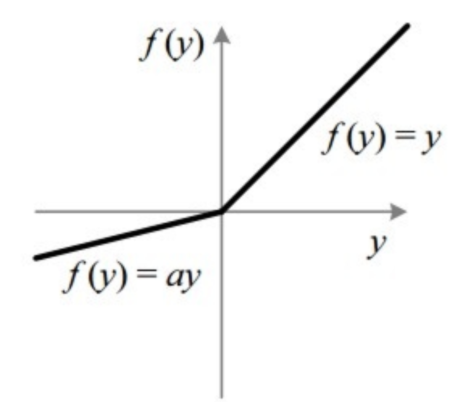
<br>
<div style="text-align: justify"><strong>Batch Normalization:</strong>il s'agit d'une méthode utilisé pour rendre le résaux de neurones artificielsplus rapides et plus stables en normalisent les données à l'entrées des couches.</div> 

In [9]:
from keras.initializers import orthogonal
import keras.models as models
import keras.layers as layers

#Encodeur
def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
                      kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

<div style="text-align: justify"><strong>Conv2DTranspose()</strong> est une opération de convolution dont le noyau est appris (tout comme l'opération conv2d normale) lors de l'entraînement de notre modèle. L'utilisation de Conv2DTranspose suréchantillonnera également son entrée, mais la principale différence est que le modèle doit apprendre quel est le meilleur suréchantillonnage pour sa tache.</div>

In [ ]:
#Décodeur
def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                               kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

#### 4.3.2 Définition du modèle  <a class="anchor" id="section_5_3_2"></a>

Nous définissons et entrainons notre modèle de la même manière que pour notre le précedent. 

In [8]:
def AutoEncdoer(input_shape):
    inputs = Input(shape=input_shape)
    
    # 256 x 256
    conv1 = Conv2DLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 64, 3, strides=2, padding='same', block_id=2)
    
    # 128 x 128
    conv3 = Conv2DLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)
    
    # 64 x 64
    conv4 = Conv2DLayer(conv3, 128, 3, strides=1, padding='same', block_id=4)
    conv5 = Conv2DLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)
    
    # 32 x 32
    conv6 = Conv2DLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)
    
    # 16 x 16
    deconv1 = Transpose_Conv2D(conv6, 512, 3, strides=2, padding='same', block_id=7)
    
    # 32 x 32
    skip1 = layers.concatenate([deconv1, conv5], name='skip1')
    conv7 = Conv2DLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    deconv2 = Transpose_Conv2D(conv7, 128, 3, strides=2, padding='same', block_id=9)
    
    # 64 x 64
    skip2 = layers.concatenate([deconv2, conv3], name='skip2')
    conv8 = Conv2DLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    deconv3 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=11)
    
    # 128 x 128
    skip3 = layers.concatenate([deconv3, conv2], name='skip3')
    conv9 = Conv2DLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    deconv4 = Transpose_Conv2D(conv9, 64, 3, strides=2, padding='same', block_id=13)
    
    # 256 x 256
    skip3 = layers.concatenate([deconv4, conv1])
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid',
                       kernel_initializer=orthogonal(), name='final_conv')(skip3)

    
    return models.Model(inputs=inputs, outputs=conv10)

model = AutoEncdoer((image_h, image_w, 3))
model_opt = tf.keras.optimizers.Adam(lr=0.002)
model.compile(optimizer=model_opt, loss='binary_crossentropy', metrics=['accuracy'])

Dans le but de donner un meilleur apreçu du modèle mise en place nous pouvons nous référer au schéma ci-dessous: 

#### 4.3.3 Sauvegarde du meilleure modèle  <a class="anchor" id="section_5_3_3"></a>

In [11]:
callback_bestmodel_improved = tf.keras.callbacks.ModelCheckpoint(filepath='./models_improved/new_model.h5', verbose=0, save_best_only=True)
callbacks_list_improved = [callback_bestmodel_improved]

#### 4.3.3 Entrainement du modèle <a class="anchor" id="section_5_3_3"></a>

In [ ]:
history = model.fit(
    x=x_train_noisy,
    y=x_train,
    epochs=nb_epochs,
    batch_size=18,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks = callbacks_list
)

#### 4.3.4 Visualisation des résultats <a class="anchor" id="section_5_3_4"></a>

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

<div style="text-align: justify"> Nous pouvons voir que les résultats obtenue sont nettement supérieur à ceux obtenue précedement et nous paraissent à première vu satisfaisant. En effet sur cette architecture la valeur de la fonction de perte et bien moins élevé que sur notre premier modèle. De plus, nous ne désselons aucune trace de sur-appretissage. Pour nous assurer de cette première impression nous avons voulu abroder des metrics qui pourrait confirmer notre analyse.</div>

## 5. Evaluation des performances de l'autoencodeur <a class="anchor" id="chapter6"></a>

<div style="text-align: justify"> Notre autoencodeur est capable de débruiter toute image bruitée avec un résultat à l'oeil nu convaincant. Evaluons à présent les performances de cet autoencodeur à l'aide de différentes métriques.
Pour l'évaluer et savoir si les images générées par ce dernier sont de qualité, nous allons utiliser des méthodes de comparaison d'images. Nous allons implémenter le <strong>MSE</strong> et le <strong>SSIM</strong></div>.

- MSE : <div style="text-align: justify">Mean-square error ou erreur moyenne quadratique est un estimateur d'erreur traditionnel. La MSE mesure,dans notre cas, la différence moyenne au carré entre les images prédites et les images originales. Il suffit donc de calculer les différences entre les images pixel par pixel. Mais cela ne fonctionne bien que si nous voulons générer une image avec les meilleures couleurs de pixel conformes à l'image de base. Dans notre cas, nous voulons nous concentrer sur la structure ou le relief de l'image pour évaluer notre autoencodeur.</div>

Pour pallier ce problème nous avons implémenté également le SSIM.

- SSIM : <div style="text-align: justify">Structural SIMilarity est une mesure de similarité entre deux images numériques. La SSIM est corrélée à la qualité et à la perception du système visuel humain. Au lieu d'utiliser les méthodes traditionnelles de sommation des erreurs, la SSIM modélise la distorsion de l'image comme une combinaison de trois facteurs qui sont la perte de corrélation, la distorsion de luminance et la distorsion de contraste.</div>

### 5.1 Import des images

Nous importons trois images : 
- une image originale
- une image bruitée
- une image générée par l'autoencodeur depuis cette même image bruitée

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from PIL import Image

size = (226,226)
#On importe et redimensionne notre image de base, la même image bruitée et l'image générée par notre denoiser
img1 = Image.open(r"C:\Users\jbcst\OneDrive\Bureau\img_base.png")
img_resize1 = img1.resize(size)
img = img_as_float(img_resize1)

img2 = Image.open(r"C:\Users\jbcst\OneDrive\Bureau\img_noise.png")
img_resize2 = img2.resize(size)
img_noise = img_as_float(img_resize2)

img3 = Image.open(r"C:\Users\jbcst\OneDrive\Bureau\img_final.png")
img_resize3 = img3.resize(size)
img_const = img_as_float(img_resize3)

### 5.2 Implémentation de la MSE et du SSIM

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min(), multichannel=True)

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise,
                  data_range=img_noise.max() - img_noise.min(), multichannel=True)

mse_const = mean_squared_error(img, img_const)
ssim_const = ssim(img, img_const,
                  data_range=img_const.max() - img_const.min(), multichannel=True)

ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}')
ax[0].set_title('Image Originale')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_xlabel(f'MSE: {mse_noise:.2f}, SSIM: {ssim_noise:.2f}')
ax[1].set_title('Image bruitée')

ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_xlabel(f'MSE: {mse_const:.2f}, SSIM: {ssim_const:.2f}')
ax[2].set_title('Image générée')

plt.tight_layout()
plt.show()

### 5.3 Interprétation des résultats

<div style="text-align: justify">Nous affichons les valeurs de MSE et de SSIM pour chacune de nos images. Le but étant d'avoir la MSE la plus proche de 0 et  une valeur de SSIM la plus proche de 1 possible. Nous voyons donc notre valeur de MSE pour notre image générée est de 0,01 donc proche de 0, cependant la MSE de l'image bruitée est de 0,04 donc nous ne pouvons pas nous baser sur cette valeur pour évaluer notre modèle.</div>
Voyons voir du coté du SSIM : 
Nous avons une valeur de 0,79 pour l'image générée.

## 6. Etude de cas <a class="anchor" id="chapter7"></a>

<div style="text-align: justify">Dans le but, d'attester des bonnes performance de notre modèle nous avons descidé de réaliser une étude de cas. Nous nous centrerons sur le traitement d'une image bruité que nous devrons importer et convertir dans le but de la rendre exploitable par le modèle. Nous passerons l'image bruité en entrée de notre modèle et analyserons la sortie.</div>

### 6.1 Chargement de l'image 

<div style="text-align: justify">Dans un premier temps nous devons importer notre image dans le notebook. Pour nous assurer de la véracité des résultats de notre étude nous avons choisie une image tiré d'internet au préalable bruité. Le code ci-dessous appel la fonction prepocess utilisé pour convertir et normaliser l'image en entrée.</div> 

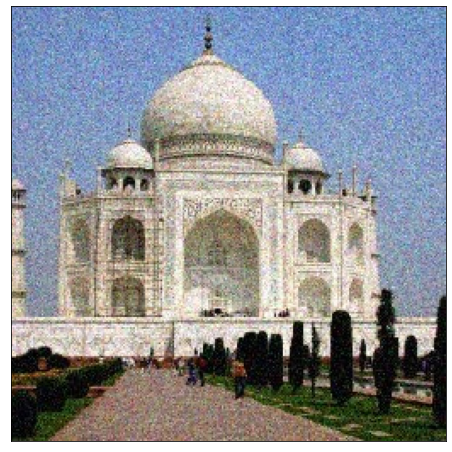

In [30]:
img = image.load_img("taj-rgb-noise.jpg", target_size=(256, 256))
img_convert = preprocess(img, is_batch = False)
display_image(img_convert, n=1, size = 8)

### 6.2 Débruitage de la photo

<div style="text-align: justify">Nous allons pouvoir maintenant passer notre photo dans l'algorithme afin qu'elle puisse se faire débruiter. Pour ce faire nous avons au préalable sauvgarder les poids de notre modèle dans le but d'optimiser le processus en therme de temps.</div>

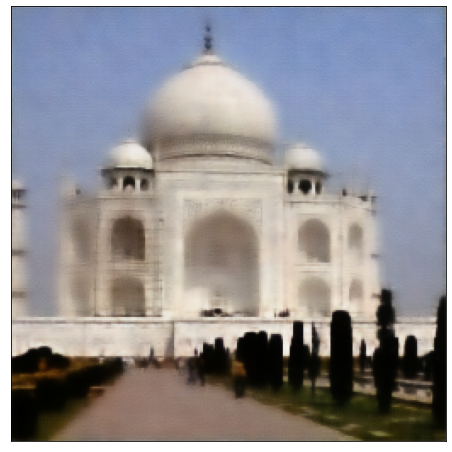

In [31]:
model_dir = r"C://Users//jujub//Option_DataScience//repo2//models_improved//best_model.h5"
model = tf.keras.models.load_model(model_dir)
predictions = model.predict(img_convert)
display_image(predictions, 1, size=8)

<div style="text-align: justify">La sortie de notre DAE nous semble correcte. En effet, nous arrivons a reconnaitre le Tajmal et distingons le paysage environent. Néanmoins, nous constatons un perte de précision par rapport à l'image initial que nous avons quantifié dans la partie <strong>5. Mesure de la performance du model</strong>. Cette perte d'information se matérialise par l'apparétion de flou sur la photo.</div>

## 7. Conclusion 

<div style="text-align: justify">L'objectif de ce notebook était de débruité une image afin de la rendre utilisable par les algorithmes de machine learning. Pour ce faire nous avons pu nous reposer sur les acquis du livrables 1 en therme d'import de blibliothèque et d'utilisation du GPU. Néanmoins, pour préparer notre dataset il a fallu bruité nos données pour pouvoir entrainer notre modèle. Suite à cela nous avons du chercher un modèle qui correspond à notre problème et nos contraintes.</div><br>

<div style="text-align: justify">Notre choix c'est dirigé tout naturellement vers l'Autoencodeur. Néanmoins, après avoir tester de nombreuse combinaison de couche et de filtre nos résultats n'était pas à la hauteur de nos attentes. Dans une démarche d'améliorer nos résultats nous avons chercher et trouvé une achitecture tiré de la littérature que nous avons implémenter. Les résultats qui en découle sont bon et sont confirmer par une étude des performance. Pour finir nous avons décider de réaliser une étude de cas pour attester nos résultats.</div>